# Carlini and Wagner L2 Attack

In [1]:

import torch
from PIL import Image
from IPython import display

import pandas as pd
import torchvision
from torchvision import transforms
import os
import sys
import numpy as np
import matplotlib.pyplot as plt


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [3]:
#load the model from the pytorch hub
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', weights='MobileNet_V2_Weights.DEFAULT', verbose=False)

# Put model in evaluation mode
model.eval()

# put the model on a GPU if available, otherwise CPU
model.to(device);

# Define the transforms for preprocessing
preprocess = transforms.Compose([
    transforms.Resize(256),  # Resize the image to 256x256
    transforms.CenterCrop(224),  # Crop the image to 224x224 about the center
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # Normalize the image with the ImageNet dataset mean values
        std=[0.229, 0.224, 0.225]  # Normalize the image with the ImageNet dataset standard deviation values
    )
]);

unnormalize = transforms.Normalize(
   mean= [-m/s for m, s in zip([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])],
   std= [1/s for s in [0.229, 0.224, 0.225]]
)

In [4]:
def tensor_to_pil(img_tensor):
    # tensor: pre-processed tensor object resulting from preprocess(img).unsqueeze(0)
    unnormed_tensor = unnormalize(img_tensor)
    return transforms.functional.to_pil_image(unnormed_tensor[0])

In [5]:
# load labels
with open("../data/labels.txt", 'r') as f:
    labels = [label.strip() for label in f.readlines()]

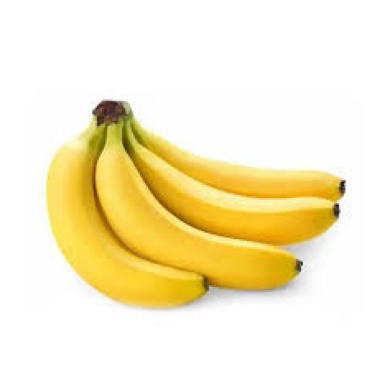

In [6]:
# load an example image
img = Image.open("../data/banana.jpg")

plt.imshow(img)
plt.axis('off')
plt.show()

In [7]:
# preprocess the image
img_tensor = preprocess(img).unsqueeze(0)

print(f"Inputs information:\n---------------\nshape:{img_tensor.shape}\n")

Inputs information:
---------------
shape:torch.Size([1, 3, 224, 224])



In [8]:
# move sample to the right device
img_tensor = img_tensor.to(device)

with torch.no_grad():
    output = model(img_tensor)

In [9]:
print(f"Image tensor on device:\n---------------\n{img_tensor.device}\n")
print(f"Inputs information:\n---------------\nshape:{img_tensor.shape}\nclass: {type(img_tensor)}\n")
print(f"Shape of outputs:\n---------------\n{output.shape}\n")
print(f"Pred Index:\n---------------\n{output[0].argmax()}\n")
print(f"Pred Label:\n---------------\n{labels[output[0].argmax()]}\n")

Image tensor on device:
---------------
cpu

Inputs information:
---------------
shape:torch.Size([1, 3, 224, 224])
class: <class 'torch.Tensor'>

Shape of outputs:
---------------
torch.Size([1, 1000])

Pred Index:
---------------
954

Pred Label:
---------------
banana



## Untargeted Carlini Wagner

### Generating the Mask

In [10]:
# define how much we want to change the image 
change = 1e-3

# create new img_tensor
img_tensor = preprocess(img).unsqueeze(0)

# create the halloween mask 
mask = torch.randn_like(img_tensor)*change

# turn in into something torch can work with
mask_parameter = torch.nn.Parameter(mask)

# create the final dog + noise
masked_img_tensor = img_tensor + mask_parameter

print(f"Mask shape:\n---------------\n{mask.shape}\n")

Mask shape:
---------------
torch.Size([1, 3, 224, 224])



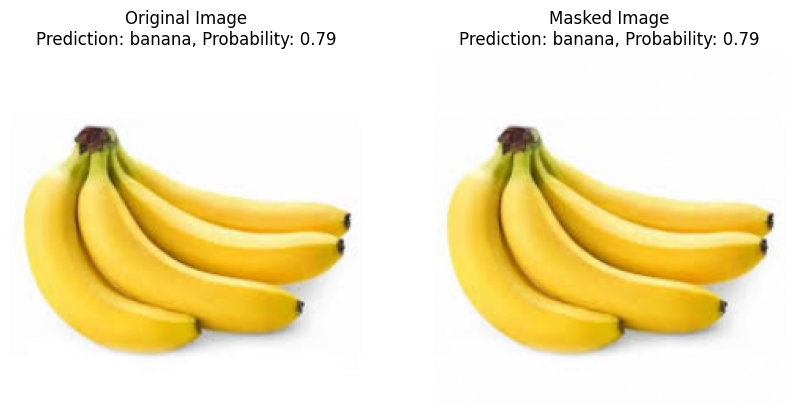

In [11]:
# get the model prediction for the original image and the masked image
# move sample to the right device

img_tensor = img_tensor.to(device)
masked_img_tensor = masked_img_tensor.to(device)

with torch.no_grad():
    output = model(img_tensor)
    masked = model(masked_img_tensor)
    
    probs = torch.softmax(output, dim=1)[0][output[0].argmax()].item()
    mask_probs = torch.softmax(masked, dim=1)[0][masked[0].argmax()].item()

    prediction = labels[output[0].argmax()]
    mask_prediction = labels[masked[0].argmax()]

    img_pil = tensor_to_pil(img_tensor)
    masked_pil = tensor_to_pil(masked_img_tensor)
    
plt.figure(figsize=(10, 5))  # Adjust the figsize as needed
plt.subplot(1, 2, 1)
plt.imshow(img_pil)
plt.title(f"Original Image\nPrediction: {prediction}, Probability: {probs:.2f}")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(masked_pil)
plt.title(f"Masked Image\nPrediction: {mask_prediction}, Probability: {mask_probs:.2f}")
plt.axis('off')

plt.show()

In [12]:
l2_norm = torch.norm(img_tensor - masked_img_tensor, p=2)
print("Distance (L2 norm) between original image and masked image:\n---------------\n", l2_norm.item())

Distance (L2 norm) between original image and masked image:
---------------
 0.3885686993598938


In [13]:
# parameters let the optimizer know how to update them (rather than just tensors, which you have to manage by hand)
mask_parameter = torch.nn.Parameter(mask.to(device))

# set the target to our mask, not the model
optimizer = torch.optim.Adam([mask_parameter])

# Find our current prediction 
current_index = model(img_tensor)[0].argmax().unsqueeze(0)

In [14]:
def loss_function(output, mask, current_index):
    # note the negative here!  We want the loss when the output does _not_ match the current index to be small.
    # usually when the two don't match, the loss is large; adding the negative sign makes it negative (thus: small)
    classification_loss = -torch.nn.functional.cross_entropy(output, current_index)
    
    # this says "No single pixel should be big, and the total magnitude of all of them should be small"
    l2_loss = torch.pow(mask, 2).sum()
    
    total_loss = classification_loss+l2_loss
    
    return total_loss, classification_loss, l2_loss

In [15]:
output = model(img_tensor + mask_parameter)
total_loss, class_loss, l2_loss = loss_function(output, mask_parameter, current_index)

optimizer.zero_grad()
total_loss.backward()
optimizer.step()

print(f"Total loss: {total_loss.item():4.4f}    class loss:{class_loss.item():4.4f}     l2 loss: {l2_loss.item():4.4f}   Predicted class index:{output[0].argmax()}")

Total loss: -0.0884    class loss:-0.2394     l2 loss: 0.1510   Predicted class index:954


In [16]:
# should be 235: German Shepherd
current_index = model(img_tensor)[0].argmax().unsqueeze(0)

# Loop until we've classified the manipulated image as something else
while True:
    # Compute the logits of the perturbed image with the current mask_parameter
    output = model(img_tensor + mask_parameter)

    # Compute the loss(es) given the current inference and the original img index
    total_loss, class_loss, l2_loss = loss_function(output, mask_parameter, current_index)

    # reset the optimizer's gradient to zero before backpropagation
    optimizer.zero_grad()

    # compute the gradients with respect to the loss and the mask_parameter
    # remember that the optimizer's target is the mask_parameter, not the model params
    total_loss.backward()

    # update the mask_parameter values based on the computed gradients
    optimizer.step()

    print("Total loss: {:4.4f}    class loss:{:4.4f}     l2 loss: {:4.4f}   Predicted class index:{}".format(
        total_loss.item(), class_loss.item(), l2_loss.item(), output[0].argmax()
    ))

    # have we achieved misclassification?
    if output[0].argmax() != current_index:
        break
        
print(f"Winner winner: {labels[output[0].argmax()]}")

Total loss: -0.4038    class loss:-0.5356     l2 loss: 0.1318   Predicted class index:954
Total loss: -0.7393    class loss:-0.9676     l2 loss: 0.2283   Predicted class index:954
Total loss: -1.0580    class loss:-1.4542     l2 loss: 0.3962   Predicted class index:954
Total loss: -1.3660    class loss:-1.9658     l2 loss: 0.5999   Predicted class index:954
Total loss: -1.6227    class loss:-2.4364     l2 loss: 0.8137   Predicted class index:954
Total loss: -1.8066    class loss:-2.8318     l2 loss: 1.0252   Predicted class index:954
Total loss: -1.9427    class loss:-3.1534     l2 loss: 1.2107   Predicted class index:954
Total loss: -2.0628    class loss:-3.4221     l2 loss: 1.3593   Predicted class index:954
Total loss: -2.1745    class loss:-3.6497     l2 loss: 1.4752   Predicted class index:954
Total loss: -2.2856    class loss:-3.8514     l2 loss: 1.5659   Predicted class index:954
Total loss: -2.3758    class loss:-4.0140     l2 loss: 1.6382   Predicted class index:954
Total loss

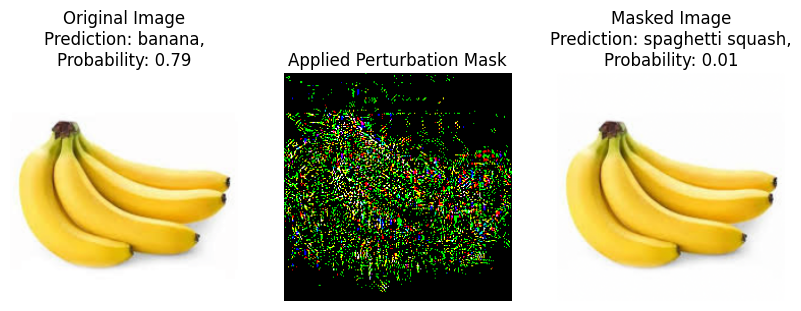

In [17]:
with torch.no_grad():
    output = model(img_tensor)
    masked = model(img_tensor + mask_parameter)
    
    probs = torch.softmax(output, dim=1)[0][output[0].argmax()].item()
    mask_probs = torch.softmax(masked, dim=1)[0][masked[0].argmax()].item()

    prediction = labels[output[0].argmax()]
    mask_prediction = labels[masked[0].argmax()]

    unnormed_img_tensor= unnormalize(img_tensor)
    unnormed_mask_tensor= unnormalize(masked_img_tensor)

    img_pil = tensor_to_pil(img_tensor)
    masked_pil = tensor_to_pil(masked_img_tensor)
    
plt.figure(figsize=(10, 5))  # Adjust the figsize as needed
plt.subplot(1, 3, 1)
plt.imshow(img_pil)
plt.title(f"Original Image\nPrediction: {prediction},\nProbability: {probs:.2f}")
plt.axis('off')

mask_pil = transforms.functional.to_pil_image(mask_parameter[0])
plt.subplot(1, 3, 2)
plt.imshow(mask_pil)
plt.title(f"Applied Perturbation Mask")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(masked_pil)
plt.title(f"Masked Image\nPrediction: {mask_prediction},\nProbability: {mask_probs:.2f}")
plt.axis('off')

plt.show()

In [18]:
masked_img_tensor = img_tensor + mask_parameter

l2_norm = torch.norm(img_tensor - masked_img_tensor, p=2)
print("Distance (L2 norm) between original image and masked image:\n---------------\n", l2_norm.item())

Distance (L2 norm) between original image and masked image:
---------------
 1.3218291997909546


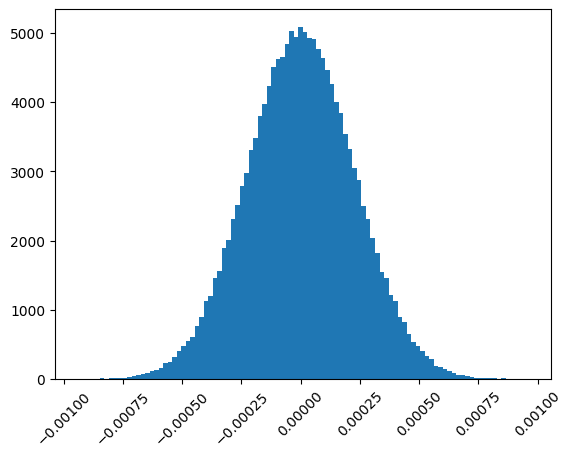

Minimum and maximum difference between the images: -0.0009424090385437012 0.0009606033563613892


In [19]:
difference = unnormed_mask_tensor - unnormed_img_tensor
difference_list = difference.view(-1).tolist()

# Plot the histogram
plt.hist(difference_list, bins=100)
plt.xticks(rotation=45)
plt.show()

print("Minimum and maximum difference between the images:", difference.min().item(), difference.max().item())

In [20]:
# save the masked img as a jpg
masked_img_tensor = img_tensor + mask_parameter
masked_pil = tensor_to_pil(masked_img_tensor)
masked_pil.save(fp='data/output.jpg')

# load the same img
new_img = Image.open("data/output.jpg")

# just evaluating, no need for gradients
with torch.no_grad():
    # preprocess, move to the right device
    jpg_img_array = preprocess(new_img).to(device).unsqueeze(0)
    # submit to the model for inference
    outputs = model(jpg_img_array)[0].argmax()

print("Target index is:", outputs)
print("Target label is:", labels[outputs])

# repeat for PNG
masked_pil.save(fp='data/output.png')

new_img = Image.open("data/output.png")

with torch.no_grad():
    png_img_array = preprocess(new_img).to(device).unsqueeze(0)
    outputs = model(png_img_array)[0].argmax()

print("Target index is:", outputs)
print("Target label is:", labels[outputs])

Target index is: tensor(954)
Target label is: banana
Target index is: tensor(954)
Target label is: banana


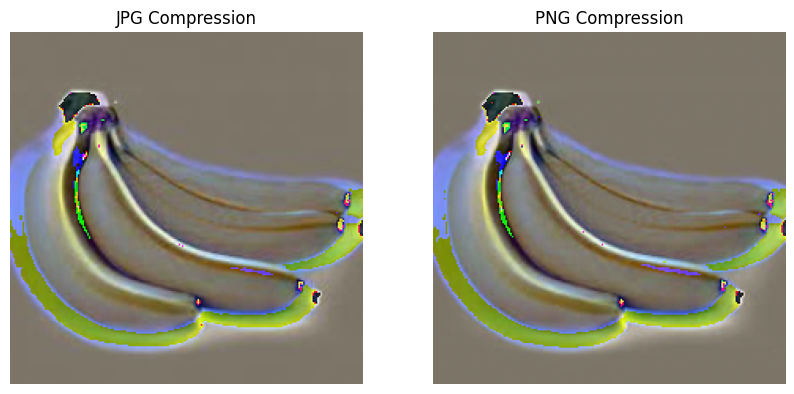

In [21]:
# visualize the compression changes

jpg_pil = tensor_to_pil(img_tensor - jpg_img_array)
png_pil = tensor_to_pil(img_tensor - png_img_array)

plt.figure(figsize=(10, 5)) 
plt.subplot(1, 2, 1)
plt.imshow(jpg_pil)
plt.title(f"JPG Compression")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(png_pil)
plt.title(f"PNG Compression")
plt.axis('off')

plt.show()

## Targeted Carlini Wagner Attack

In [22]:
# define how much we want to change the image 
change = 1e-3

# create new img_tensor
img_tensor = preprocess(img).unsqueeze(0).to(device)

# create the halloween mask 
mask = torch.randn_like(img_tensor)*change

# create the mask parameter
mask_parameter = torch.nn.Parameter(mask.to(device))

optimizer = torch.optim.Adam([mask_parameter])
target_index = model(img_tensor).argmax()

print(f"Pred Index:\n---------------\n{output[0].argmax()}\n")
print(f"Pred Label:\n---------------\n{labels[output[0].argmax()]}\n")

Pred Index:
---------------
954

Pred Label:
---------------
banana



In [23]:
# 512 is the index of 'corkscrew`
target_index = torch.tensor(labels.index('strawberry')).unsqueeze(0).to(device)
print("Target index is:\n---------------\n", target_index)

Target index is:
---------------
 tensor([949])


In [24]:
def loss(output, mask, target_index, l2_weight):
    # Now we're removing the negative, we want it to be classified as the target_index
    classification_loss = torch.nn.functional.cross_entropy(output, target_index)
    
    # this says "No single pixel should be big, and the total magnitude of all of them should be small"
    l2_loss = torch.pow(mask, 2).sum()
    
    total_loss =  classification_loss+(l2_weight * l2_loss)
    
    # Now we penalize large distortions a bit less.
    return total_loss, classification_loss, l2_loss

In [25]:
l2_weight = 0.5
step = 0

while True: # evaluate it until the prediction matches the target label
    output = model(img_tensor + mask_parameter)
    total_loss, class_loss, l2_loss = loss(output, mask_parameter, target_index, l2_weight)

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    step += 1
    
    sys.stdout.write(f"\rStep: {step}  total loss: {total_loss.item():4.4f}    class loss:{class_loss.item():4.4f}     l2 loss: {l2_loss.item():4.4f}   Predicted class index:{output[0].argmax()}");
    sys.stdout.flush()

    if output[0].argmax().item() == target_index.item():
        break

Step: 30  total loss: 3.2806    class loss:1.8336     l2 loss: 2.8941   Predicted class index:949

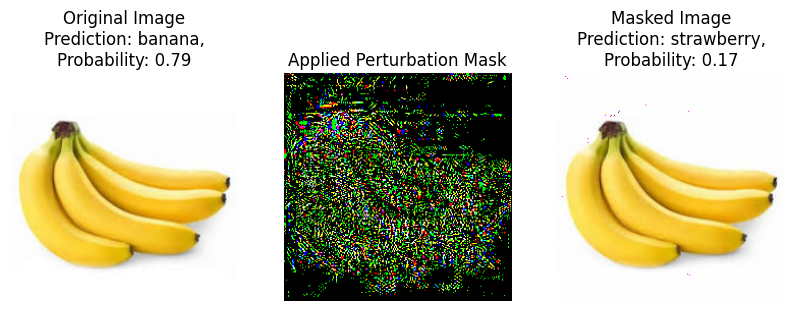

In [26]:
masked_img_tensor = img_tensor + mask_parameter

# get the model prediction and score for the original image and the masked image
with torch.no_grad():
    output = model(img_tensor)
    masked = model(masked_img_tensor)
    
    probs = torch.softmax(output, dim=1)[0][output[0].argmax()].item()
    mask_probs = torch.softmax(masked, dim=1)[0][masked[0].argmax()].item()

    prediction = labels[output[0].argmax()]
    mask_prediction = labels[masked[0].argmax()]

    img_pil = tensor_to_pil(img_tensor)
    masked_pil = tensor_to_pil(masked_img_tensor)
    
plt.figure(figsize=(10, 5))  # Adjust the figsize as needed
plt.subplot(1, 3, 1)
plt.imshow(img_pil)
plt.title(f"Original Image\nPrediction: {prediction},\nProbability: {probs:.2f}")
plt.axis('off')

mask_pil = transforms.functional.to_pil_image(mask_parameter[0])
plt.subplot(1, 3, 2)
plt.imshow(mask_pil)
plt.title(f"Applied Perturbation Mask")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(masked_pil)
plt.title(f"Masked Image\nPrediction: {mask_prediction},\nProbability: {mask_probs:.2f}")
plt.axis('off')

plt.show()

In [27]:
l2_norm = torch.norm(img_tensor - masked_img_tensor, p=2)
print("Distance (L2 norm) between original image and masked image:\n---------------\n", l2_norm.item())

Distance (L2 norm) between original image and masked image:
---------------
 1.7021404504776


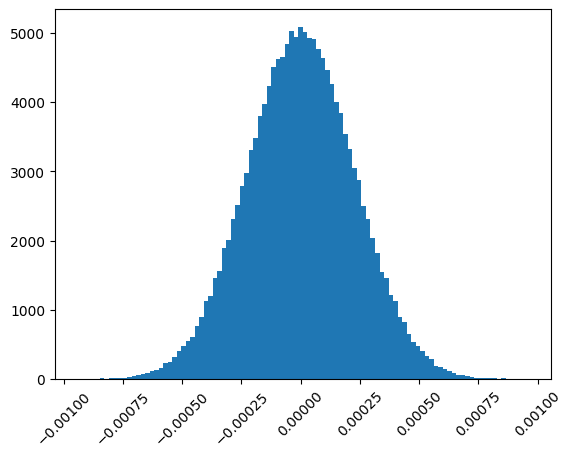

Minimum and maximum difference between the images: -0.0009424090385437012 0.0009606033563613892


In [28]:
difference = unnormed_mask_tensor - unnormed_img_tensor
difference_list = difference.view(-1).tolist()

# Plot the histogram
plt.hist(difference_list, bins=100)
plt.xticks(rotation=45)
plt.show()

print("Minimum and maximum difference between the images:", difference.min().item(), difference.max().item())